In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates


In [15]:

data = pd.read_csv("BatteryTableAllLogs.csv")
data['timestamp'] = pd.to_datetime(data['timestamp'])


## Charging life Analysis

This Analysis is attempting to analyze battery charging patterns. Based on the battery information provided, a positive current indicates charging. I assume that capacity should increase when the current is positive. 
All timestamps where the current is greater than zero will be identified, and these timeframes will be overlaid with the capacity data.


In [16]:
most_frequent = "44-4b-5d-01-04-21"

SPO2 = data.loc[(data['hostName'] == most_frequent) & (data['device'] == 'SPO2SENSOR')].sort_values(by=['timestamp'])
RESP = data.loc[(data['hostName'] == most_frequent) & (data['device'] == 'RESPSENSOR')].sort_values(by=['timestamp'])
HUB = data.loc[(data['hostName'] == most_frequent) & (data['device'] == 'HUB')].sort_values(by=['timestamp'])

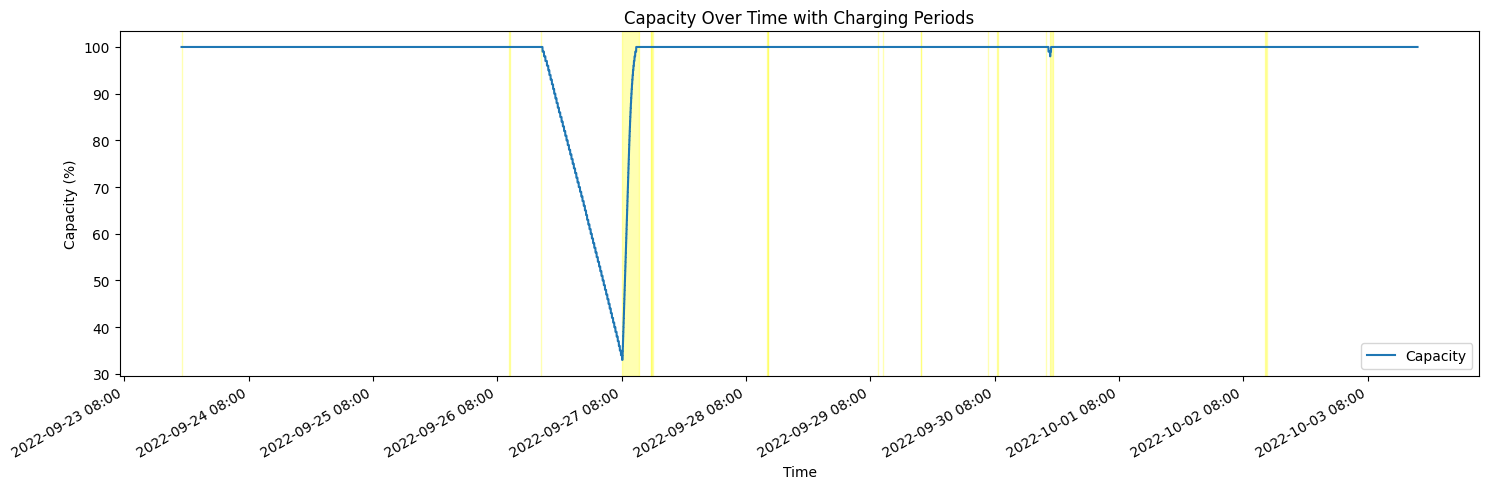

In [17]:


df = HUB.copy()
df['Charging'] = df['current'] > 0
df['Not_Charging'] = df['current'] <= 0

# identify start and end of charging
df['Charging_Start'] = df['Charging'] & ~df['Charging'].shift(1).fillna(False)
df['Charging_End'] = df['Not_Charging'] & ~df['Not_Charging'].shift(1).fillna(False)
df['Cycle_Index'] = df['Charging_Start'].cumsum()

df = df[df['Cycle_Index'] > 1]

charging_periods_list = []
start_time = None

for index, row in df.iterrows():
    if row['Charging_Start']:
        start_time = row['timestamp']
    elif row['Charging_End'] and start_time is not None:
        end_time = row['timestamp']
        charging_periods_list.append({'start': start_time, 'end': end_time, 'cycle_index': row['Cycle_Index']})
        start_time = None
charging_periods = pd.DataFrame(charging_periods_list)


#draw
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['capacity'], label='Capacity')

for _, row in charging_periods.iterrows():
    plt.axvspan(row['start'], row['end'], color='yellow', alpha=0.3)

plt.title('Capacity Over Time with Charging Periods')
plt.xlabel('Time')
plt.ylabel('Capacity (%)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=24))
plt.gcf().autofmt_xdate() 

plt.legend()
plt.tight_layout()
plt.show()




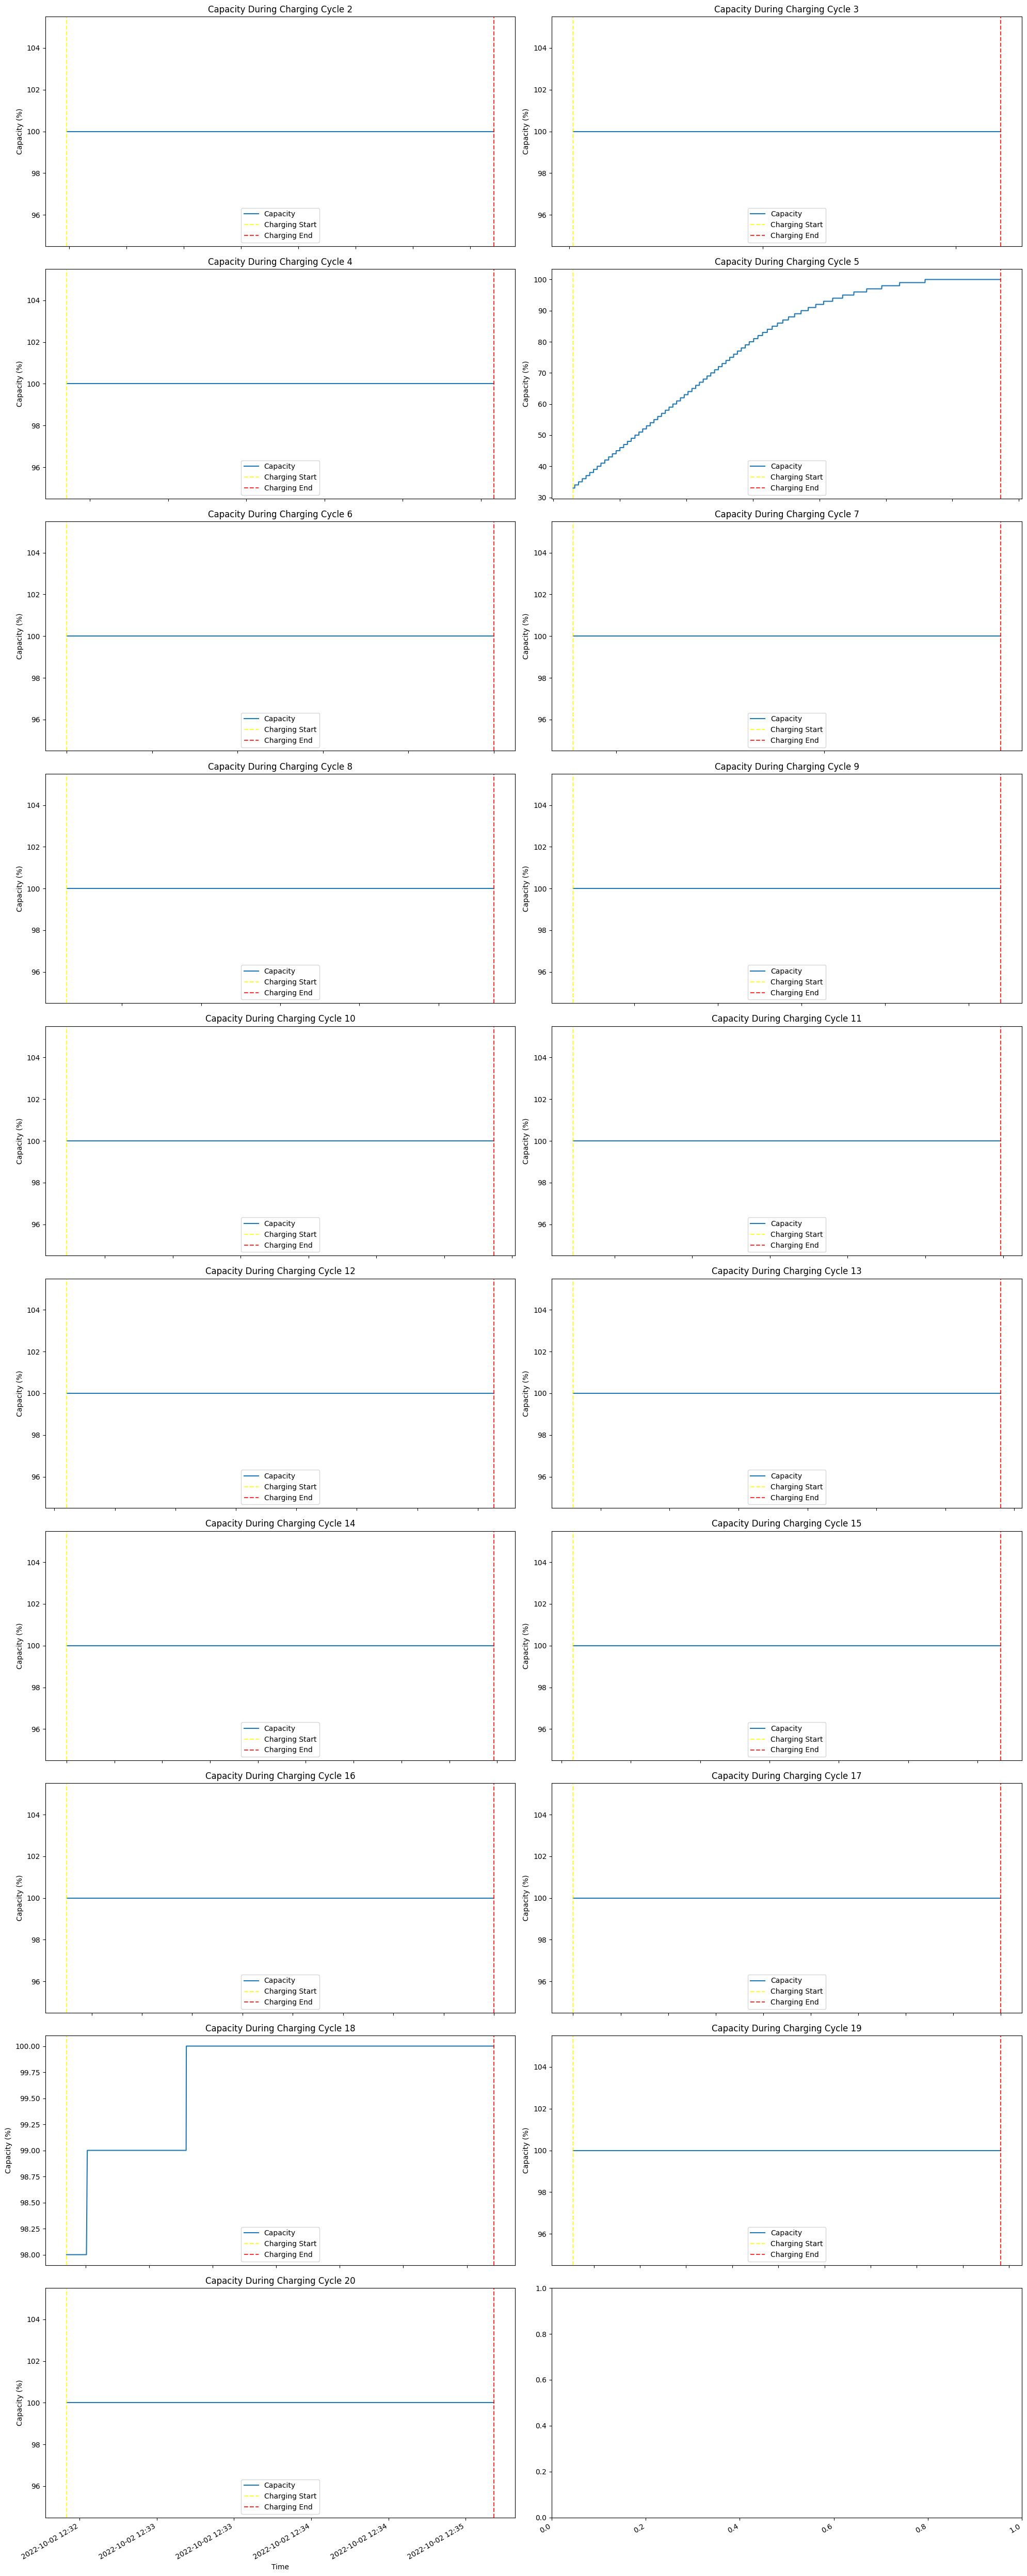

In [18]:

num_rows = int(np.ceil(len(charging_periods) / 2))  
fig, axs = plt.subplots(num_rows, 2, figsize=(20, 5 * num_rows))  

axs = axs.flatten()

for i, (index, cycle) in enumerate(charging_periods.iterrows()):
    ax = axs[i]

    start_time = cycle['start']
    end_time = cycle['end']
    
    cycle_data = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)]
    
    ax.plot(cycle_data['timestamp'], cycle_data['capacity'], label='Capacity')
    ax.axvline(x=start_time, color='yellow', linestyle='--', alpha=0.8, label='Charging Start')
    ax.axvline(x=end_time, color='red', linestyle='--', alpha=0.8, label='Charging End')
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.autofmt_xdate()

    ax.set_title(f'Capacity During Charging Cycle {cycle["cycle_index"]}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Capacity (%)')
    ax.legend()



plt.tight_layout()
plt.show()


In [19]:
summary_df = pd.DataFrame(columns=['Cycle_Index', 'Charging time(s)', 'Max Voltage', 
                                   'Min Voltage'])

for cycle_index, group in df.groupby('Cycle_Index'):
    
    # calculate discharing time
    discharge_times = group.loc[group['current'] < 0, 'timestamp']
    if not discharge_times.empty:
        discharge_time = ((discharge_times.iloc[-1] - discharge_times.iloc[0]).total_seconds() )
    else:
        discharge_time = 0  
    
    # calculate charing time
    charge_times = group.loc[group['current'] > 0, 'timestamp']
    if not charge_times.empty:
        charge_time = ((charge_times.iloc[-1] - charge_times.iloc[0]).total_seconds() )
    else:
        charge_time = 0  
    
    max_voltage = group['voltage'].max()
    min_voltage = group['voltage'].min()
    
    summary_df = summary_df.append({
        'Cycle_Index': cycle_index,
        'Max Voltage': max_voltage,
        'Min Voltage': min_voltage,
        'Charging time(s)': charge_time
    }, ignore_index=True)

summary_df.to_csv('summary_data.csv', index=False)

print(summary_df)


    Cycle_Index  Charging time(s)  Max Voltage  Min Voltage
0           2.0             447.0       4083.0       4060.0
1           3.0             662.0       4083.0       4012.0
2           4.0             163.0       4083.0       3495.0
3           5.0           11568.0       4083.0       3732.0
4           6.0               0.0       4083.0       4083.0
5           7.0             607.0       4084.0       4009.0
6           8.0             323.0       4083.0       4061.0
7           9.0             304.0       4083.0       4021.0
8          10.0             188.0       4083.0       4020.0
9          11.0             329.0       4083.0       4063.0
10         12.0             105.0       4083.0       4019.0
11         13.0              30.0       4083.0       4082.0
12         14.0             133.0       4084.0       4066.0
13         15.0             180.0       4083.0       4067.0
14         16.0              84.0       4083.0       4067.0
15         17.0               8.0       

/var/folders/qm/w7f8y2y92dd90qvxq4hlyt6m0000gn/T/ipykernel_13271/3384692355.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({
/var/folders/qm/w7f8y2y92dd90qvxq4hlyt6m0000gn/T/ipykernel_13271/3384692355.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({
/var/folders/qm/w7f8y2y92dd90qvxq4hlyt6m0000gn/T/ipykernel_13271/3384692355.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({
/var/folders/qm/w7f8y2y92dd90qvxq4hlyt6m0000gn/T/ipykernel_13271/3384692355.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.appen

## User Battery Daily Capcity Usage Analysis

The analysis focuses on assessing the daily usage patterns of the battery. This is achieved by calculating the difference between the maximum and minimum values for each battery on a daily basis. This method effectively captures the extent of battery charge and discharge cycles within a 24-hour period, providing insight into the operational capacity and usage trends of the battery.

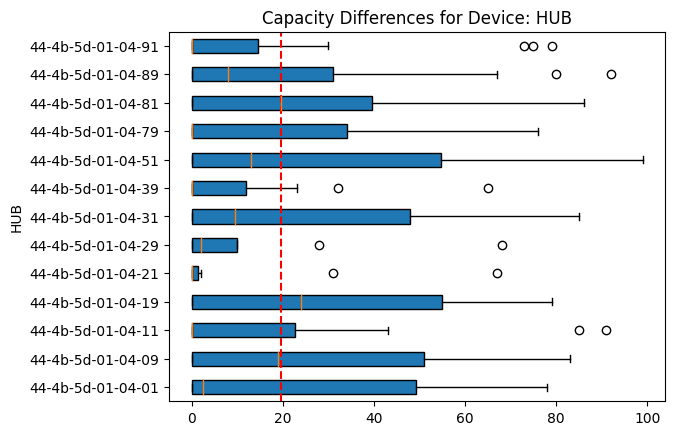

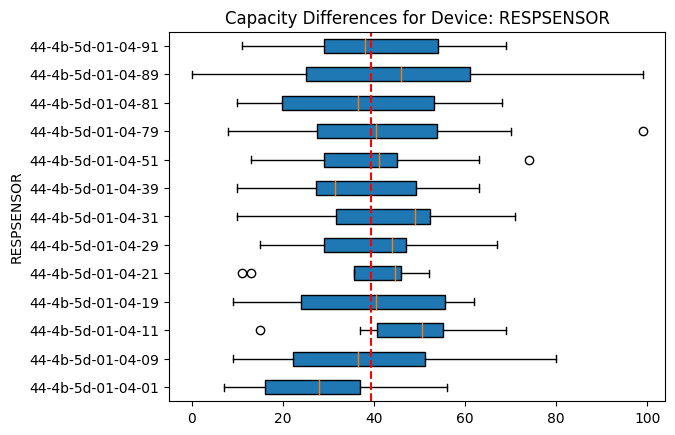

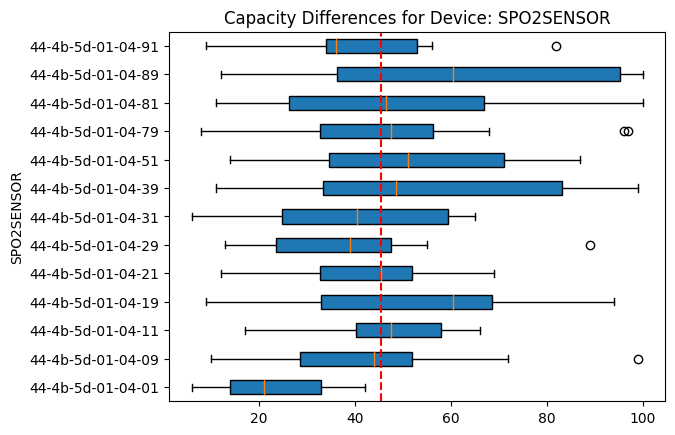

In [13]:

for device, group_data in data.groupby('device'):

    boxes = []  
    y_labels = []
    device_mean = []

    for name, group in group_data.groupby('hostName'):

        group['timestamp'] = pd.to_datetime(group['timestamp'])
        group = group.set_index('timestamp')
        
        grouped = group.resample('D') 

        daily_max = grouped['capacity'].max()
        daily_min = grouped['capacity'].min()

        differences = daily_max - daily_min
        differences = differences.dropna()  
        mean = differences.mean()

        if mean >= 5:
            boxes.append(differences.values)
            device_mean.append(mean)
            y_labels.append(name)
        
    plt.boxplot(boxes, vert=False, patch_artist=True) 
    plt.ylabel(device)
    plt.yticks(range(1, len(y_labels) + 1), y_labels)
    plt.axvline(x=np.mean(device_mean), color='r', linestyle='--', label='mean')
    plt.title(f'Capacity Differences for Device: {device}')
    plt.show()
